# Predicting survival on the Titanic
This is the second in a series of analyses I'm doing on famous datasets. The first was an analysis of the iris dataset, which can also be found on my github. As with the iris analysis, my goal is not to reinvent the wheel here. My goal is to educate both myself and anyone who deigns to read this notebook. In particular, with this analysis I'd like to focus on two specific topics:
1. Feature selection and engineering - for this I'll draw heavily on the fantastic R notebook posted by Megan Risdal to Kaggle at https://www.kaggle.com/mrisdal/titanic/exploring-survival-on-the-titanic
2. Model selection and validation - the techniques I'll use here are drawn from a variety of sources, most notably the 'Parallel Machine Learning with Python' notebooks by Olivier Grisel, availabale here: https://github.com/ogrisel/parallel_ml_tutorial

## Load data

In [198]:
import pandas as pd
df = pd.read_csv('train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 90.5+ KB


It appears we have data for 891 passengers. However, not every column has 891 values. That's something we'll need to keep in mind and rectify in the next section.

## Feature engineering overview
Before we can build a classifier, we need to do some work to clean up the features of this dataset. For the sake of this analysis, I'll break down the feature engineering work we need to do into 2 components:
1. Filling in missing values for existing features - Some of the columns are missing values (Age, Cabin, Embarked). We'll need to do some work here to make sure our final dataset has the full number of values for each feature.
2. Creating new features - We can extract some additional information from the columns in the dataset (for example, map surnames to a new 'Family' feature). 

## Filling missing values
Based on the summary of the dataframe above, we have 3 columns that we need to figure out how to fill in:
1. Age - Missing ~175 values
2. Cabin - Missing ~500 values
3. Embarked - Missing 2 values  
  
There are generally 3 approaches to filling missing values in a dataset:
1. Remove the rows in question
2. Fill in values with some sort of mean/median statistic
3. Predict the missing values based on the values of other features  
  
For this analysis, we'll show how to do both 2 and 3. We won't be eliminating any rows since this dataset is quite small, and it's rarely the best way to handle missing values anyways. We'll start by filling in the missing 'embarked' values. We'll plan on using the mode to fill these in (note: prediction using other features would likely end up being more accurate. I wanted to demonstrate how to fill in values based on summary statistics and decided to do it with 'embarked' because it's only missing 2 values).  

Sidebar - the chapter at http://www.stat.columbia.edu/~gelman/arm/missing.pdf was very helpful in learning about various methods to impute missing values.

First, let's examine the 'embarked' variable:

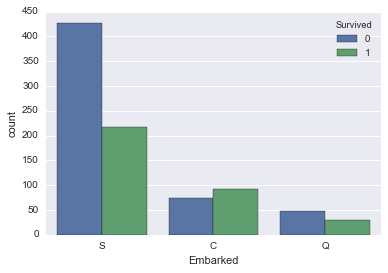

In [199]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
surv_plot = sns.countplot(x='Embarked', hue="Survived", data=df)

Looks like the vast majority of passengers embarked at Port S. However, passengers at Port S had a higher chance of dying than the others. Let's do some quick checks to see if it looks like it's because of the port itself, or a different variable:

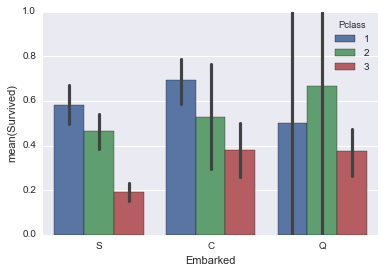

In [200]:
embark_plot = sns.barplot(x="Embarked", y="Survived", hue="Pclass", data=df)

Now let's take a closer look at the passengers that are missing the 'Embarked' feature:

In [201]:
df.groupby('Survived').count()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Survived,,,,,,,,,,,
0,549,549,549,549,424,549,549,549,549,68,549
1,342,342,342,342,290,342,342,342,342,136,340


Looks like both of the passengers missing the 'Embarked' feature ended up surviving. Let's look at the rows themselves:

In [202]:
df[pd.isnull(df['Embarked'])]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38,0,0,113572,80,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62,0,0,113572,80,B28,NaN


So they're both women in the same cabin. Let's take a look at their cabin before we impute the values:

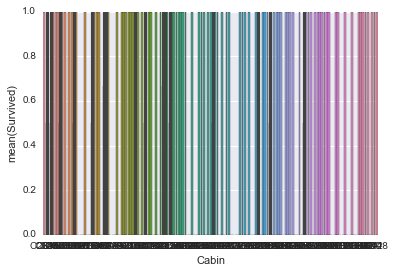

In [203]:
cabin_plot = sns.barplot(x='Cabin',y='Survived',data=df)

That didn't work too well. Let's take a look at the values cabin can take - it looks like there are too many values to examine in this fashion.

In [204]:
df.Cabin.unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6', 'C23 C25 C27',
       'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33', 'F G73', 'E31',
       'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101', 'F E69', 'D47',
       'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4', 'A32', 'B4',
       'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35', 'C87', 'B77',
       'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19', 'B49', 'D',
       'C22 C26', 'C106', 'C65', 'E36', 'C54', 'B57 B59 B63 B66', 'C7',
       'E34', 'C32', 'B18', 'C124', 'C91', 'E40', 'T', 'C128', 'D37',
       'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44', 'A34', 'C104', 'C111',
       'C92', 'E38', 'D21', 'E12', 'E63', 'A14', 'B37', 'C30', 'D20',
       'B79', 'E25', 'D46', 'B73', 'C95', 'B38', 'B39', 'B22', 'C86',
       'C70', 'A16', 'C101', 'C68', 'A10', 'E68', 'B41', 'A20', 'D19',
       'D50', 'D9', 'A23', 'B50', 'A26', 'D48', 'E58', 'C126', 'B71',
       'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63', 'C62 C64', 'E24',

There are definitely more discrete values for cabin than we'd like to show a relationship between the specific cabin and where someone embarked. However, this list does suggest another feature we can create. We can just take the first letter of the cabin and use that to create a new feature called 'Deck'. Let's do that and see where people embarked by deck.

In [205]:
decks = df['Cabin'].apply(lambda x: x[0] if not pd.isnull(x) else x)
deck_series = pd.Series(decks)
df['Deck'] = deck_series
df.Deck.unique()

array([nan, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

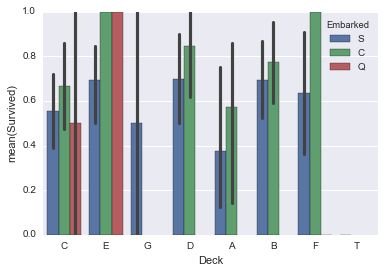

In [206]:
deck_plot = sns.barplot(x='Deck', y='Survived', hue = 'Embarked', data=df)

So the port of embarkation didn't have much of an impact on survival rate relative to their cabin. At this point, I'm happy to impute the values for 'Embarked' as the mode of the column (port S).

In [207]:
df['Embarked'] = df['Embarked'].fillna('S')
df.groupby('Embarked').count()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Deck
Embarked,,,,,,,,,,,,
C,168,168,168,168,168,130,168,168,168,168,69,69
Q,77,77,77,77,77,28,77,77,77,77,4,4
S,646,646,646,646,646,556,646,646,646,646,131,131


In [208]:
df[df['PassengerId'].isin([62,830])]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck
61,62,1,1,"Icard, Miss. Amelie",female,38,0,0,113572,80,B28,S,B
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62,0,0,113572,80,B28,S,B


And so the 'embarked' feature was imputed correctly. Now let's move on to the 'age' feature. For this, we'll try and see if we can predict it using some of the other features. In particular, I have a hypothesis that we can use the following features to impute age to some degree of accuracy:
1. SibSp - Number of siblings or spouses aboard. If this is >1 it may indicate younger people with multiple siblings.
2. Parch - Number of parents/children aboard. If this is >2, it probably means someone has children, and thus is older.

Let's look at SibSp and Parch:

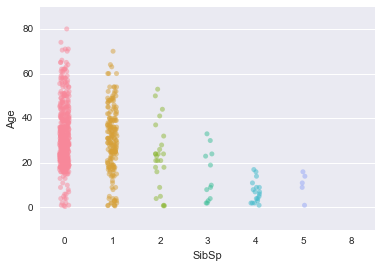

In [209]:
sibsp_plot = sns.stripplot(x='SibSp',y='Age',data=df,alpha=0.5, jitter=True)

Looks like there's definitely an inverse relationship between SibSp and Age. Now let's look at Parch:

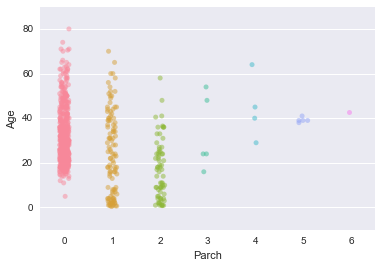

In [210]:
parch_plot = sns.stripplot(x='Parch',y='Age',data=df, jitter=True, alpha=0.5)

The relationship here's not so clear, but it does look like if you have no parents or children on board, you were likely 15+, while people with 1 or 2 parents/children on board skewed younger. Let's now create our predictor for imputing age. We need to convert some of our non-numeric columns to numeric first.

In [211]:
#numerical_features = df[['SibSp', 'Parch', 'Pclass','Fare']].copy(deep=True)
#non_numerical_features = df[['Sex','Embarked','Deck']]
# Note - you can use sklearn's OneHotEncoder to create binary features from categorical features, 
# but I find it a bit clumsy to use. Also, we're not using deck or cabin here because we haven't 
# imputed their values yet.

# Encode sex binary
sex_series = df['Sex'].apply(lambda x: 1 if x == 'female' else 0)

# let's examine the embarked values before converting to binary features
non_numerical_features['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [212]:
embarked_S_series = df['Embarked'].apply(lambda x: 1 if x == 'S' else 0)
embarked_C_series = df['Embarked'].apply(lambda x: 1 if x == 'C' else 0)
embarked_Q_series = df['Embarked'].apply(lambda x: 1 if x == 'Q' else 0)

In [225]:
df['Gender'] = sex_series
df['Embarked_S'] = embarked_S_series
df['Embarked_C'] = embarked_C_series
df['Embarked_Q'] = embarked_Q_series
del df['Sex']
del df['Embarked']
df.info()

KeyError: 'Sex'

Now let's split the data into 2 sets (one where ages are non-nan, one with nan ages).

In [214]:
training_set = df[df['Age'].isnull()==False]
prediction_set = df[df['Age'].isnull()==True]
print "Training set shape: {0}, {1}".format(training_set.shape[0], training_set.shape[1])
print "Prediction set shape: {0}, {1}".format(prediction_set.shape[0], prediction_set.shape[1])

Training set shape: 714, 15
Prediction set shape: 177, 15


Now let's split the training set into the features and target (age), and train our linear regression classifier.

In [215]:
labels = list(training_set['Age'])
features =  training_set[['SibSp','Parch','Pclass','Fare','Gender','Embarked_S','Embarked_C','Embarked_Q']].as_matrix()

from sklearn.linear_model import LinearRegression
LR = LinearRegression(fit_intercept=True)
LR.fit(features,labels)
print LR.score(features,labels)

0.241856923105


That's not particularly good. Let's try another approach. We don't really care about the exact age. What really matters for prediction is whether someone is a child, young adult, or adult. Let's build a discrete variable based on this idea and try some other classifiers for prediction.

In [232]:
# pick some arbitrary bounds for age groups - we can optimize these bounds later, but that's for another post
def get_age_group(age):
    if age < 12: # Children
        return 1
    elif age < 17: # Young adults
        return 2
    elif age < 45: # Adults
        return 3
    elif age <100: # Seniors
        return 4
    else:
        return age
age_groups = df['Age'].apply(get_age_group)
df['Age'] = age_groups
training_set.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Gender,Embarked_S,Embarked_C,Embarked_Q
count,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000
mean,448.582633,0.406162,2.236695,2.925770,0.512605,0.431373,34.694514,0.365546,0.778711,0.182073,0.039216
std,259.119524,0.491460,0.838250,0.762981,0.929783,0.853289,52.918930,0.481921,0.415405,0.386175,0.194244
min,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,222.250000,0.000000,1.000000,3.000000,0.000000,0.000000,8.050000,0.000000,1.000000,0.000000,0.000000
50%,445.000000,0.000000,2.000000,3.000000,0.000000,0.000000,15.741700,0.000000,1.000000,0.000000,0.000000
75%,677.750000,1.000000,3.000000,3.000000,1.000000,1.000000,33.375000,1.000000,1.000000,0.000000,0.000000
max,891.000000,1.000000,3.000000,4.000000,5.000000,6.000000,512.329200,1.000000,1.000000,1.000000,1.000000


Now let's build our classifier for predicting age group. We'll split our training_set into 2 components to fit and test on. We'll start by trying a random forest for prediction.

In [217]:
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# split into features and labels, grabbing only numerical predictors
labels = list(training_set['Age'])
features =  training_set[['SibSp','Parch','Pclass','Fare','Gender','Embarked_S','Embarked_C','Embarked_Q']].as_matrix()

X_fit, X_test, y_fit, y_predict = train_test_split(features,labels, test_size = 0.33)
rf = RandomForestClassifier()

rf.fit(X_fit,y_fit)
pred_train = rf.predict(X_fit)
pred = rf.predict(X_test)
print "Accuracy score of random forest on training data: %r"%accuracy_score(y_fit,pred_train)
print "Accuracy score of random forest on test data: %r"%accuracy_score(y_predict,pred)

Accuracy score of random forest on training data: 0.90167364016736407
Accuracy score of random forest on test data: 0.63983050847457623


68% isn't too bad, but such a big discrepancy between the accuracy on the fitting set and the test set suggests overfitting. Let's see if we can get a little better by doing a grid search of some of the parameters of the random forest model.

In [218]:
import numpy as np
from sklearn.grid_search import GridSearchCV

parameters = {'n_estimators':[10,100,500],
             'criterion': ['gini','entropy'],
             'max_depth': [None, 5, 10],
             'min_samples_split': [2,5,10,25]}

rf = RandomForestClassifier()
clf = GridSearchCV(rf,parameters)
clf.fit(X_fit,y_fit)
pred_train = clf.predict(X_fit)
pred = clf.predict(X_test)

print "Accuracy score of random forest on training data: %r"%accuracy_score(y_fit,pred_train)
print "Accuracy score of random forest on test data: %r"%accuracy_score(y_predict,pred)
print "Best parameters found by grid search: %r"%clf.best_params_

Accuracy score of random forest on training data: 0.76778242677824271
Accuracy score of random forest on test data: 0.72881355932203384
Best parameters found by grid search: {'min_samples_split': 10, 'n_estimators': 100, 'criterion': 'gini', 'max_depth': 5}


Now we're up to about 75%. This is pretty good! Having the test and fit set accuracy so close together means we aren't overfitting. One last thing we'll do for fun before filling in our nan values is to check out which features are most important to the random forest.

In [219]:
rf_best = clf.best_estimator_
importances = rf_best.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_best.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
column_values = ['SibSp','Parch','Pclass','Fare','Gender','Embarked_S','Embarked_C','Embarked_Q']

print "Feature ranking:"
for f in range(X_fit.shape[1]):
    print("%d. feature %r (%f)" % (f + 1, column_values[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature 'Fare' (0.283987)
2. feature 'SibSp' (0.236449)
3. feature 'Parch' (0.209467)
4. feature 'Pclass' (0.139602)
5. feature 'Gender' (0.051926)
6. feature 'Embarked_C' (0.034302)
7. feature 'Embarked_S' (0.028773)
8. feature 'Embarked_Q' (0.015494)


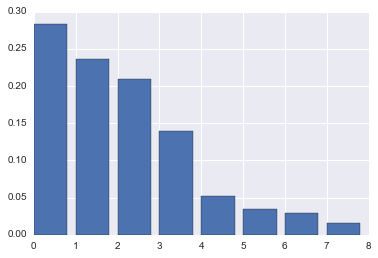

In [220]:
sorted_cols = [column_values[index] for index in indices]
sorted_importances = [importances[index] for index in indices]
plot = plt.bar(range(len(importances)), sorted_importances)

So our hypothesis was accurate - SibSp and Parch are important in predicting age, in addition to Fare and Pclass. Fare being the best predictor is interesting - maybe children and seniors paid less? Unsurprisingly, Gender, and the various embarked features don't seem to have much of an effect.  

Now we're ready to fill in the 'Age' column using our random forest. Remember that we converted the ages given into an age group. Let's do this for the full dataset. One thing I'd like to mention is that I'm not sure of the most efficient way to do this so I'm going to hack it together. Let me know if you're reading this and I'm missing something easy.

First, we make predictions for the rows with missing ages.

In [237]:
features_predict =  prediction_set[['SibSp','Parch','Pclass','Fare','Gender','Embarked_S','Embarked_C','Embarked_Q']].\
as_matrix()
predictions = clf.predict(features_predict)

Now we need to get the indices of the rows of the original dataframe with missing ages.

In [222]:
nan_indices = df[df['Age'].isnull()].index.tolist()
print nan_indices

[5, 17, 19, 26, 28, 29, 31, 32, 36, 42, 45, 46, 47, 48, 55, 64, 65, 76, 77, 82, 87, 95, 101, 107, 109, 121, 126, 128, 140, 154, 158, 159, 166, 168, 176, 180, 181, 185, 186, 196, 198, 201, 214, 223, 229, 235, 240, 241, 250, 256, 260, 264, 270, 274, 277, 284, 295, 298, 300, 301, 303, 304, 306, 324, 330, 334, 335, 347, 351, 354, 358, 359, 364, 367, 368, 375, 384, 388, 409, 410, 411, 413, 415, 420, 425, 428, 431, 444, 451, 454, 457, 459, 464, 466, 468, 470, 475, 481, 485, 490, 495, 497, 502, 507, 511, 517, 522, 524, 527, 531, 533, 538, 547, 552, 557, 560, 563, 564, 568, 573, 578, 584, 589, 593, 596, 598, 601, 602, 611, 612, 613, 629, 633, 639, 643, 648, 650, 653, 656, 667, 669, 674, 680, 692, 697, 709, 711, 718, 727, 732, 738, 739, 740, 760, 766, 768, 773, 776, 778, 783, 790, 792, 793, 815, 825, 826, 828, 832, 837, 839, 846, 849, 859, 863, 868, 878, 888]


One last thing I'd like to do before we fill in the values is add an additional column that keeps track of whether age is missing. We didn't do this for 'embark' because it was only 2 values, but for age there may be a particular reason that the values were missing. If we fill them in blindly, we'll lose that information. Later we'll do this for cabin as well.

In [236]:
df['missing_age'] = df['Age'].apply(lambda x: 0 if x in [0,1,2,3,4] else 1)

Now let's create our series of predictions and fill in the values for missing ages using fillna.

In [250]:
pred_series = pd.Series(data = predictions, index = nan_indices)
df.loc[df['Age'].isnull(),'Age'] = pred_series[df.loc[df['Age'].isnull()].index]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 16 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Deck           204 non-null object
Gender         891 non-null int64
Embarked_S     891 non-null int64
Embarked_C     891 non-null int64
Embarked_Q     891 non-null int64
missing_age    891 non-null int64
dtypes: float64(2), int64(10), object(4)
memory usage: 118.3+ KB


Finally! We've successfully filled in values for age. Now let's quickly handle cabin/deck. It's not really worth imputing values for these since less than 25% of the passengers have data; whatever we do will likely introduce significant bias into our model. Let's do three things:
1. Eliminate the 'Cabin' column altogether - what deck they're on is likely significantly more important than the specific room.
2. Create a set of binary features based on what deck they were on.
3. Create another binary feature to indicate whether or not they were missing cabin data.

In [253]:
df['Deck'].unique()

array([nan, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [254]:
deck_c = df['Deck'].apply(lambda x: 1 if x == 'C' else 0)
deck_e = df['Deck'].apply(lambda x: 1 if x == 'C' else 0)
deck_g = df['Deck'].apply(lambda x: 1 if x == 'C' else 0)
deck_d = df['Deck'].apply(lambda x: 1 if x == 'C' else 0)
deck_a = df['Deck'].apply(lambda x: 1 if x == 'C' else 0)
deck_b = df['Deck'].apply(lambda x: 1 if x == 'C' else 0)
deck_f = df['Deck'].apply(lambda x: 1 if x == 'C' else 0)
deck_t = df['Deck'].apply(lambda x: 1 if x == 'C' else 0)
missing_deck = df['Deck'].apply(lambda x: 0 if x in ['C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'] else 1)

Now let's add columns for each of these and delete the originals:

In [255]:
df['deck_c'] = deck_c
df['deck_e'] = deck_e
df['deck_g'] = deck_g
df['deck_d'] = deck_d
df['deck_a'] = deck_a
df['deck_b'] = deck_b
df['deck_f'] = deck_f
df['deck_t'] = deck_t
df['missing_deck'] = missing_deck
del df['Deck']
del df['Cabin']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 23 columns):
PassengerId     891 non-null int64
Survived        891 non-null int64
Pclass          891 non-null int64
Name            891 non-null object
Age             891 non-null float64
SibSp           891 non-null int64
Parch           891 non-null int64
Ticket          891 non-null object
Fare            891 non-null float64
Gender          891 non-null int64
Embarked_S      891 non-null int64
Embarked_C      891 non-null int64
Embarked_Q      891 non-null int64
missing_age     891 non-null int64
deck_c          891 non-null int64
deck_e          891 non-null int64
deck_g          891 non-null int64
deck_d          891 non-null int64
deck_a          891 non-null int64
deck_b          891 non-null int64
deck_f          891 non-null int64
deck_t          891 non-null int64
missing_deck    891 non-null int64
dtypes: float64(2), int64(19), object(2)
memory usage: 167.1+ KB


Now we have 2 more columns to handle: Name and Ticket. Let's look at the Ticket column first:

In [256]:
df['Ticket'].head(10)

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
5              330877
6               17463
7              349909
8              347742
9              237736
Name: Ticket, dtype: object

In [257]:
len(df['Ticket'].unique())

681

681 unique values out of 891 data points. It looks like the column is just the number of the ticket purchase. We can probably safely remove this column. Let's do that.

In [258]:
del df['Ticket']

Now let's look at the passenger names. For the most part, these won't be too helpful. The one thing I'd like to do is extract the title from each name. Let's take a look at the possible titles:

In [259]:
df['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [263]:
titles = df['Name'].apply(lambda x: x.split(', ')[1].split()[0].strip('.'))
print titles.value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Col           2
Mlle          2
Jonkheer      1
Ms            1
Lady          1
the           1
Don           1
Mme           1
Capt          1
Sir           1
Name: Name, dtype: int64


Now let's condense these to a smaller, standardized set of titles:

In [265]:
title_mapping = {'Mr': 'mr',
                'Miss': 'miss',
                'Mrs': 'mrs',
                'Master': 'mr',
                'Mlle': 'miss',
                'Ms': 'miss',
                'Mme': 'mrs'}
condensed_titles = titles.apply(lambda x: title_mapping[x] if x in title_mapping else 'rare')
condensed_titles.value_counts()

mr      557
miss    185
mrs     126
rare     23
Name: Name, dtype: int64

Now let's create binary features for each title and add them to the dataframe:

In [266]:
is_mr = condensed_titles.apply(lambda x: 1 if x == 'mr' else 0)
is_miss = condensed_titles.apply(lambda x: 1 if x == 'miss' else 0)
is_mrs = condensed_titles.apply(lambda x: 1 if x == 'mrs' else 0)
is_rare = condensed_titles.apply(lambda x: 1 if x == 'rare' else 0)

df['is_mr'] = is_mr
df['is_miss'] = is_miss
df['is_mrs'] = is_mrs
df['is_rare'] = is_rare

del df['Name']

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 25 columns):
PassengerId     891 non-null int64
Survived        891 non-null int64
Pclass          891 non-null int64
Age             891 non-null float64
SibSp           891 non-null int64
Parch           891 non-null int64
Fare            891 non-null float64
Gender          891 non-null int64
Embarked_S      891 non-null int64
Embarked_C      891 non-null int64
Embarked_Q      891 non-null int64
missing_age     891 non-null int64
deck_c          891 non-null int64
deck_e          891 non-null int64
deck_g          891 non-null int64
deck_d          891 non-null int64
deck_a          891 non-null int64
deck_b          891 non-null int64
deck_f          891 non-null int64
deck_t          891 non-null int64
missing_deck    891 non-null int64
is_mr           891 non-null int64
is_miss         891 non-null int64
is_mrs          891 non-null int64
is_rare         891 non-null int64
dtypes: float64(

And we're ready to go! All columns are filled in with numeric values. We're ready to build our classifier.

## Building the classifier
Whew, that took a while. Feature engineering can be tedious but it's incredibly important. Now let's build a classifier and see how accurate we can get. Let's start by creating our test and train datasets.

In [272]:
labels = list(df['Survived'])
features = df.ix[:,'Pclass':].as_matrix()

X_train, X_test, y_train, y_predict = train_test_split(features,labels, test_size = 0.33)

Now let's build our classifier. We have a lot of binary data and a small number of categories, so we'll start with a random forest again.

In [273]:
parameters = {'n_estimators':[10,100,500],
             'criterion': ['gini','entropy'],
             'max_depth': [None, 5, 10],
             'min_samples_split': [2,5,10,25]}

rf = RandomForestClassifier()
clf = GridSearchCV(rf,parameters)
clf.fit(X_train,y_train)
pred_train = clf.predict(X_train)
pred = clf.predict(X_test)

print "Accuracy score of random forest on training data: %r"%accuracy_score(y_train,pred_train)
print "Accuracy score of random forest on test data: %r"%accuracy_score(y_predict,pred)
print "Best parameters found by grid search: %r"%clf.best_params_

Accuracy score of random forest on training data: 0.86577181208053688
Accuracy score of random forest on test data: 0.8203389830508474
Best parameters found by grid search: {'min_samples_split': 10, 'n_estimators': 10, 'criterion': 'entropy', 'max_depth': 10}
